# Simple Weighted Attention Mechanism

## Dependencies

In [1]:
import torch

torch.manual_seed(123)

# Your journey starts with one step
context = torch.tensor(
  [
    [0.43, 0.15, 0.86], # Your
    [0.55, 0.87, 0.66], # journey
    [0.57, 0.85, 0.64], # starts 
    [0.22, 0.58, 0.33], # with
    [0.77, 0.25, 0.10], # one
    [0.05, 0.80, 0.55] # step
  ]
)

context.shape

torch.Size([6, 3])

## Weight Tensors

Let's create:
* W_query
* W_key
* W_value

In [2]:
d = context[0].shape
d

torch.Size([3])

In [3]:
d_in = d[0]
d_out = d[0]

d_in, d_out

(3, 3)

Initialize the weight tensors with random values

In [4]:
W_query = torch.rand(d_in, d_out)
W_key = torch.rand(d_in, d_out)
W_value = torch.rand(d_in, d_out)

W_query, W_key, W_value

(tensor([[0.2961, 0.5166, 0.2517],
         [0.6886, 0.0740, 0.8665],
         [0.1366, 0.1025, 0.1841]]),
 tensor([[0.7264, 0.3153, 0.6871],
         [0.0756, 0.1966, 0.3164],
         [0.4017, 0.1186, 0.8274]]),
 tensor([[0.3821, 0.6605, 0.8536],
         [0.5932, 0.6367, 0.9826],
         [0.2745, 0.6584, 0.2775]]))

In [7]:
x_2 = context[1]
x_2

tensor([0.5500, 0.8700, 0.6600])

In [8]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

query_2, key_2, value_2

(tensor([0.8520, 0.4161, 1.0138]),
 tensor([0.7305, 0.4227, 1.1993]),
 tensor([0.9074, 1.3518, 1.5075]))

Do the same thing for all the other corresponding inputs

In [9]:
keys = context @ W_key
values = context @ W_value

keys, values

(tensor([[0.6692, 0.2670, 1.0545],
         [0.7305, 0.4227, 1.1993],
         [0.7355, 0.4227, 1.1901],
         [0.3363, 0.2225, 0.6077],
         [0.6184, 0.3038, 0.6909],
         [0.3178, 0.2383, 0.7426]]),
 tensor([[0.4893, 0.9457, 0.7531],
         [0.9074, 1.3518, 1.5075],
         [0.8976, 1.3391, 1.4994],
         [0.5187, 0.7319, 0.8493],
         [0.4699, 0.7336, 0.9307],
         [0.6446, 0.9045, 0.9814]]))

In [10]:
attention_scores_2 = query_2 @ keys.T
attention_scores_2

tensor([1.7503, 2.0141, 2.0091, 0.9952, 1.3538, 1.1227])

In [11]:
d_k = d_out

attention_weights_2 = torch.softmax(attention_scores_2 / d_k**0.5, dim=-1)
attention_weights_2

tensor([0.1830, 0.2131, 0.2125, 0.1184, 0.1456, 0.1274])

In [12]:
attention_weights_2.sum()

tensor(1.)

In [13]:
context_vec_2 = attention_weights_2 @ values
context_vec_2

tensor([0.6856, 1.0544, 1.1388])

## Generalize for entire input context

In [14]:
d_k = d_out

x_batch = context

keys = x_batch @ W_key
queries = x_batch @ W_query
values = x_batch @ W_value

attention_scores = queries @ keys.T
attention_weights = torch.softmax(attention_scores / d_k**0.5, dim=-1)
context_vecs = attention_weights @ values

context_vecs

tensor([[0.6679, 1.0240, 1.1094],
        [0.6856, 1.0544, 1.1388],
        [0.6853, 1.0538, 1.1382],
        [0.6728, 1.0328, 1.1173],
        [0.6700, 1.0274, 1.1130],
        [0.6773, 1.0408, 1.1247]])

## TTNN implementation

In [15]:
import os
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}" 

In [16]:
os.environ.get("TTNN_CONFIG_OVERRIDES")

'{"enable_fast_runtime_mode": false}'

In [17]:
import torch
import ttnn
from ttnn.tracer import trace, visualize

torch.manual_seed(123)

# Your journey starts with one step
context = torch.tensor(
  [
    [0.43, 0.15, 0.86], # Your
    [0.55, 0.87, 0.66], # journey
    [0.57, 0.85, 0.64], # starts 
    [0.22, 0.58, 0.33], # with
    [0.77, 0.25, 0.10], # one
    [0.05, 0.80, 0.55] # step
  ]
)

context.shape

torch.Size([6, 3])

Create the query, key and value weight tensors in `torch` and then we can create the TTNN tiled versions using `ttnn.from_torch`.

In [18]:
d = context[0].shape
d_in = d[0]
d_out = d[0]

d_in, d_out

(3, 3)

In [19]:
with trace():
  context_ttnn = ttnn.from_torch(context, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)

  W_query = torch.rand(d_in, d_out)
  W_key = torch.rand(d_in, d_out)
  W_value = torch.rand(d_in, d_out)

  W_query_ttnn = ttnn.from_torch(W_query, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)
  W_key_ttnn = ttnn.from_torch(W_key, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)
  W_value_ttnn = ttnn.from_torch(W_value, dtype=ttnn.bfloat16, layout=ttnn.TILE_LAYOUT)

W_query_ttnn, W_key_ttnn, W_value_ttnn

                 Always | INFO     | Begin op: tt::tt_metal::detail::convert_python_tensor_to_tt_tensor
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<pybind11::handle const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Layout>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::Tile> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
            

(ttnn.Tensor([[ 0.29688,  0.51562,  0.25195],
              [ 0.68750,  0.07373,  0.86719],
              [ 0.13672,  0.10254,  0.18359]], shape=Shape([3, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 ttnn.Tensor([[ 0.72656,  0.31445,  0.68750],
              [ 0.07568,  0.19629,  0.31641],
              [ 0.40234,  0.11865,  0.82812]], shape=Shape([3, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 ttnn.Tensor([[ 0.38281,  0.66016,  0.85547],
              [ 0.59375,  0.63672,  0.98438],
              [ 0.27539,  0.66016,  0.27734]], shape=Shape([3, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE))

 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<float>
                 Always | INFO     | End op: Tensor::pad
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | Begin op: Tensor::to_layout
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Layout>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | End op: Tensor::to_layout
                 Always | INFO     | Ten

2025-05-17 10:51:39.330 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-17 10:51:39.339 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-17 10:51:39.340 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


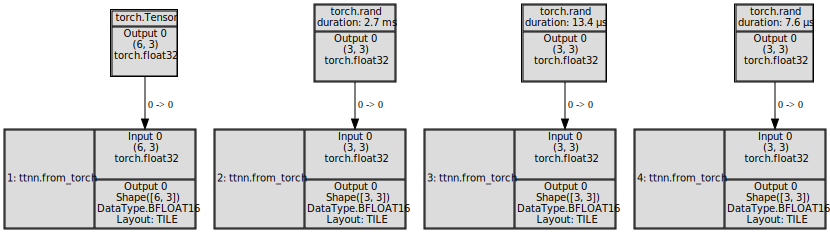

In [20]:
visualize(W_query_ttnn)
visualize(W_key_ttnn)
visualize(W_value_ttnn)

In [21]:
device_id = 0
device = ttnn.open_device(device_id=device_id)

                 Device | INFO     | 

New chip! We now have 1 chips
Chip initialization complete (found )
Chip initializing complete...
 ARC

 [4/4] DRAM

 [16/16] ETH

 CPU

Chip detection complete (found )


Opening user mode device driver
2025-05-17 10:53:09.657 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled

2025-05-17 10:53:09.677 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-17 10:53:09.679 | INFO     | SiliconDriver   - Harvesting mask for chip 0 is 0x200 (physical layout: 0x1, logical: 0x200, simulated harvesting mask: 0x0).
2025-05-17 10:53:09.681 | INFO     | SiliconDriver   - Opened PCI device 0; KMD version: 1.33.0, IOMMU: disabled
2025-05-17 10:53:09.681 | INFO     | SiliconDriver   - Detected PCI devices: [0]
2025-05-17 10:53:09.681 | INFO     | SiliconDriver   - Using local chip ids: {0} and remote chip ids {}
2025-05-17 10:53:09.781 | INFO     | SiliconDriver   - Software version 6.0.0, Ethernet FW version 6.14.0 (Device 0)
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
                  Metal | INFO     | AI CLK for device 0 is:   1000 MHz


In [22]:
with trace():
  context_ttnn = ttnn.to_device(context_ttnn, device)

  W_query_ttnn = ttnn.to_device(W_query_ttnn, device)
  W_key_ttnn = ttnn.to_device(W_key_ttnn, device)
  W_value_ttnn = ttnn.to_device(W_value_ttnn, device)


                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device
                 Always | INFO     | Begin op: Tensor::to_device
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: Tensor::to_device
                 Always | INFO     | B

2025-05-17 10:55:11.313 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-17 10:55:11.321 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-17 10:55:11.322 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


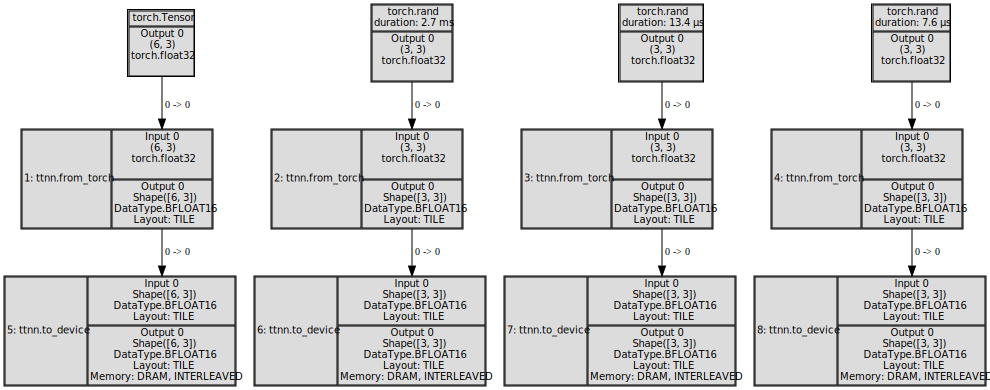

In [23]:
visualize(W_query_ttnn)
visualize(W_key_ttnn)
visualize(W_value_ttnn)

In [24]:
with trace():
  keys_ttnn = ttnn.matmul(context_ttnn, W_key_ttnn)
  values_ttnn = ttnn.matmul(context_ttnn, W_value_ttnn)
  queries_ttnn = ttnn.matmul(context_ttnn, W_query_ttnn)

keys_ttnn, values_ttnn, queries_ttnn

                 Always | INFO     | Begin op: ttnn::matmul

(ttnn.Tensor([[ 0.67188,  0.26562,  1.05469],
              [ 0.72656,  0.42188,  1.19531],
              ...,
              [ 0.61719,  0.30273,  0.69141],
              [ 0.31641,  0.23730,  0.73828]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 ttnn.Tensor([[ 0.49023,  0.94922,  0.75781],
              [ 0.90625,  1.34375,  1.50781],
              ...,
              [ 0.47070,  0.73047,  0.92969],
              [ 0.64453,  0.90234,  0.98047]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE),
 ttnn.Tensor([[ 0.34961,  0.32031,  0.39648],
              [ 0.85156,  0.41211,  1.01562],
              ...,
              [ 0.41211,  0.42383,  0.42773],
              [ 0.64062,  0.14062,  0.80469]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE))


                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCast1DProgramConfig, ttnn::operations::ma

2025-05-17 10:59:07.584 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-17 10:59:07.589 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None
2025-05-17 10:59:07.595 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


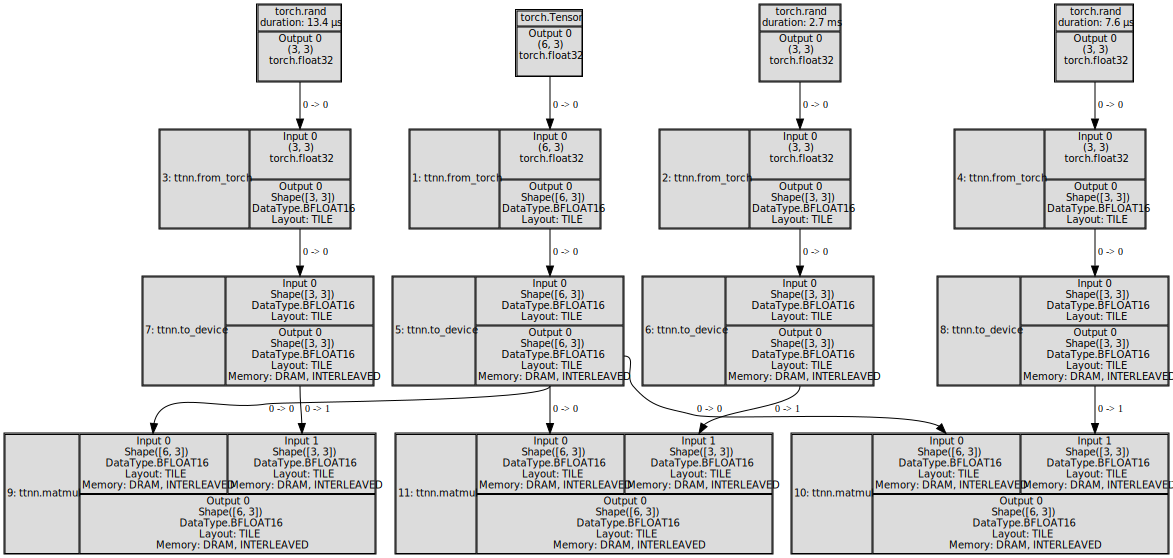

In [27]:
visualize(keys_ttnn)
visualize(values_ttnn)
visualize(queries_ttnn)

## Transposing a ttnn tensor

We can use `ttnn.permute` to transpose a ttnn tensor

In [29]:
with trace():
  keys_transposed_ttnn = ttnn.permute(keys_ttnn, (1, 0))
  keys_transposed_ttnn

                 Always | INFO     | Begin op: ttnn::permute
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::stl::StrongType<unsigned char, ttnn::QueueIdTag>>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::stl::SmallVector<long, 8ul> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<float> const>
                 Always | INFO     | Begin op: ttnn::reshape
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::stl::StrongType<unsigned char, ttnn::QueueIdTag> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape>
                 Always | INFO     | input any type n

2025-05-17 11:04:50.014 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


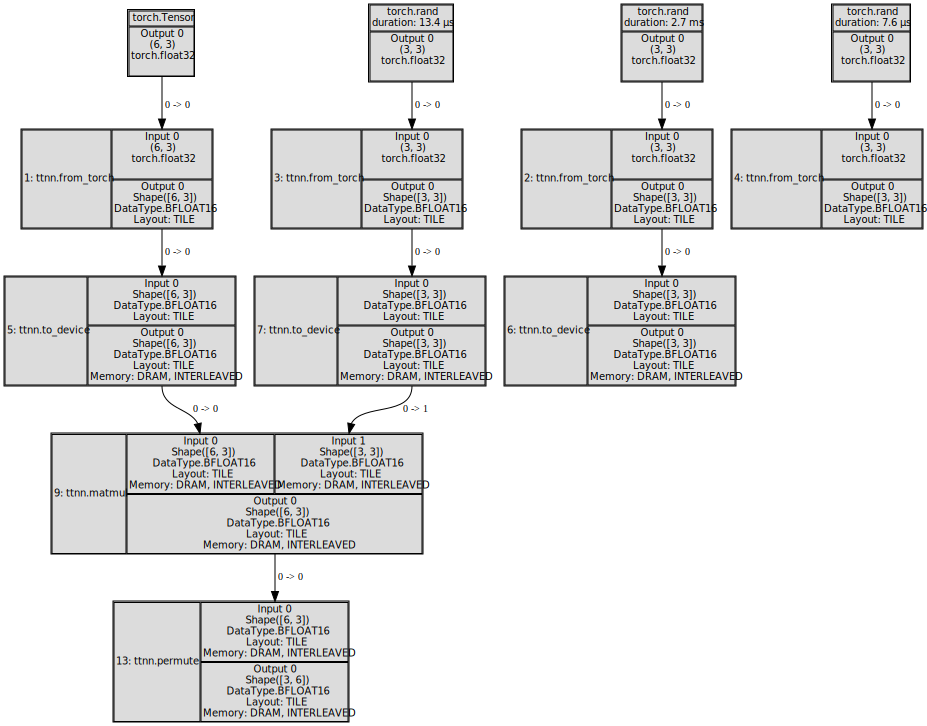

In [30]:
visualize(keys_transposed_ttnn)

In [31]:
with trace():
  attention_scores_ttnn = ttnn.matmul(queries_ttnn, keys_transposed_ttnn)
  attention_scores_scaled_ttnn = ttnn.div(attention_scores_ttnn, d_k ** 0.5)
  attention_weights_ttnn = ttnn.softmax(attention_scores_scaled_ttnn, dim=-1)

attention_weights_ttnn

                 Always | INFO     | Begin op: ttnn::matmul
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulM

ttnn.Tensor([[ 0.17383,  0.18555,  ...,  0.15918,  0.14941],
             [ 0.18457,  0.20898,  ...,  0.13965,  0.12207],
             ...,
             [ 0.17383,  0.18652,  ...,  0.16016,  0.14746],
             [ 0.17578,  0.20020,  ...,  0.14941,  0.13867]], shape=Shape([6, 6]), dtype=DataType::BFLOAT16, layout=Layout::TILE)

| input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Shape const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::DataType>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::Layout>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::IDevice*>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::tt_metal::MemoryConfig const>
                 Always | INFO     | End op: tt::tt_metal::create_device_tensor
                 Always | INFO     | End op: Matmul
                 Always | INFO     | End op: ttnn::prim::old_infra_device_operation
                 Always | INFO     | End op: ttnn::matmul
                 Always | INFO     | Begin op: ttnn::div
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<tt::stl::

2025-05-17 11:07:10.092 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


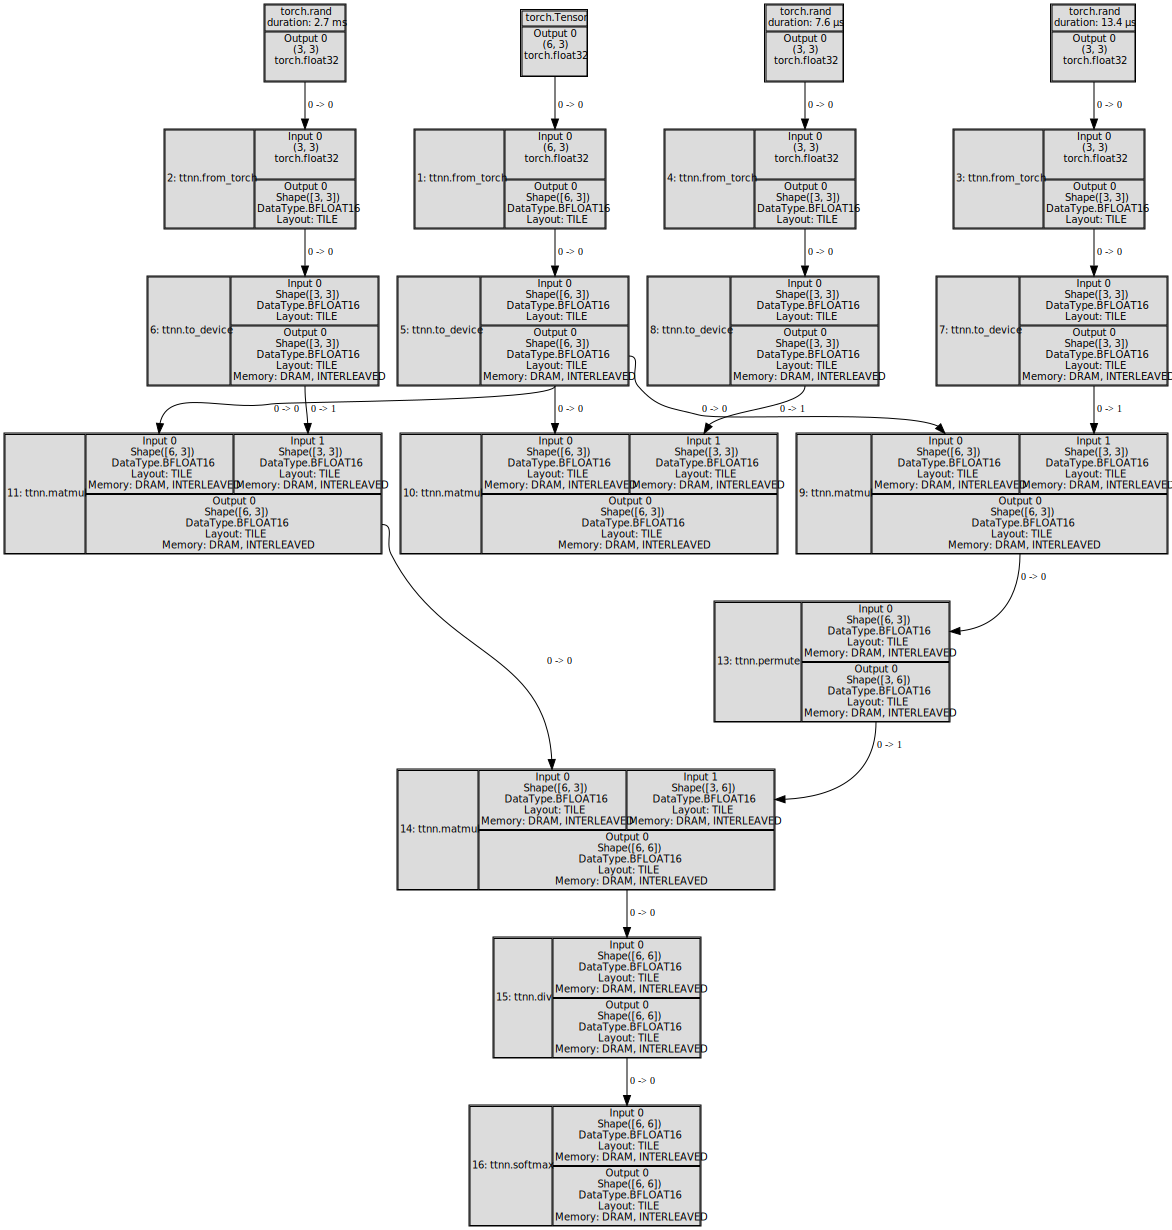

In [32]:
visualize(attention_weights_ttnn)

In [33]:
with trace():
  context_vecs_ttnn = ttnn.matmul(attention_weights_ttnn, values_ttnn)

context_vecs_ttnn

                 Always | INFO     | Begin op: ttnn::matmul

ttnn.Tensor([[ 0.66406,  1.01562,  1.10156],
             [ 0.67188,  1.03906,  1.11719],
             ...,
             [ 0.66406,  1.01562,  1.10156],
             [ 0.67188,  1.03125,  1.11719]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE)


                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::MemoryConfig const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<tt::tt_metal::DataType const> const>
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<std::__1::optional<std::__1::variant<ttnn::operations::matmul::MatmulMultiCoreProgramConfig, ttnn::operations::matmul::MatmulMultiCoreNonOptimizedReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCastProgramConfig, ttnn::operations::matmul::MatmulMultiCoreReuseMultiCast1DProgramConfig, ttnn::operations::ma

2025-05-17 11:09:26.500 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


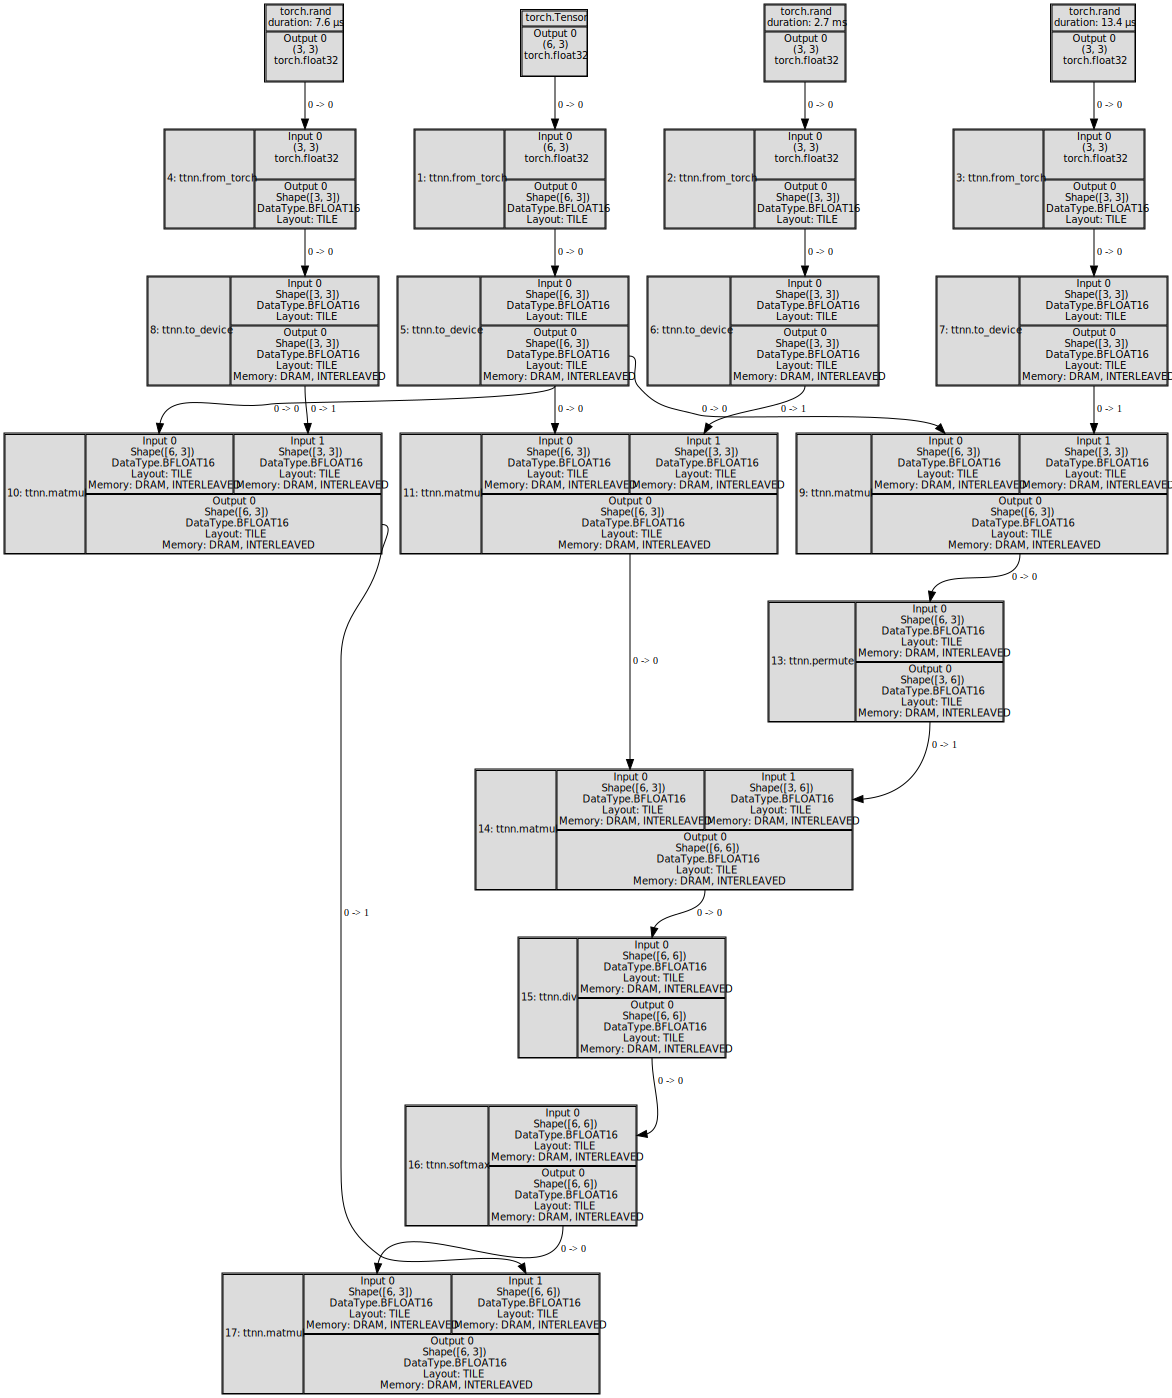

In [34]:
visualize(context_vecs_ttnn)

In [35]:
with trace():
  context_vecs_ttnn = ttnn.from_device(context_vecs_ttnn)

                 Always | INFO     | Begin op: Tensor::cpu
                 Always | INFO     | input any type name ignored: std::__1::reference_wrapper<bool>
                 Always | INFO     | End op: Tensor::cpu
                 Always | INFO     | Tensor doesn't have buffer, but storage is tt::tt_metal::OwnedStorage


2025-05-17 11:10:33.963 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


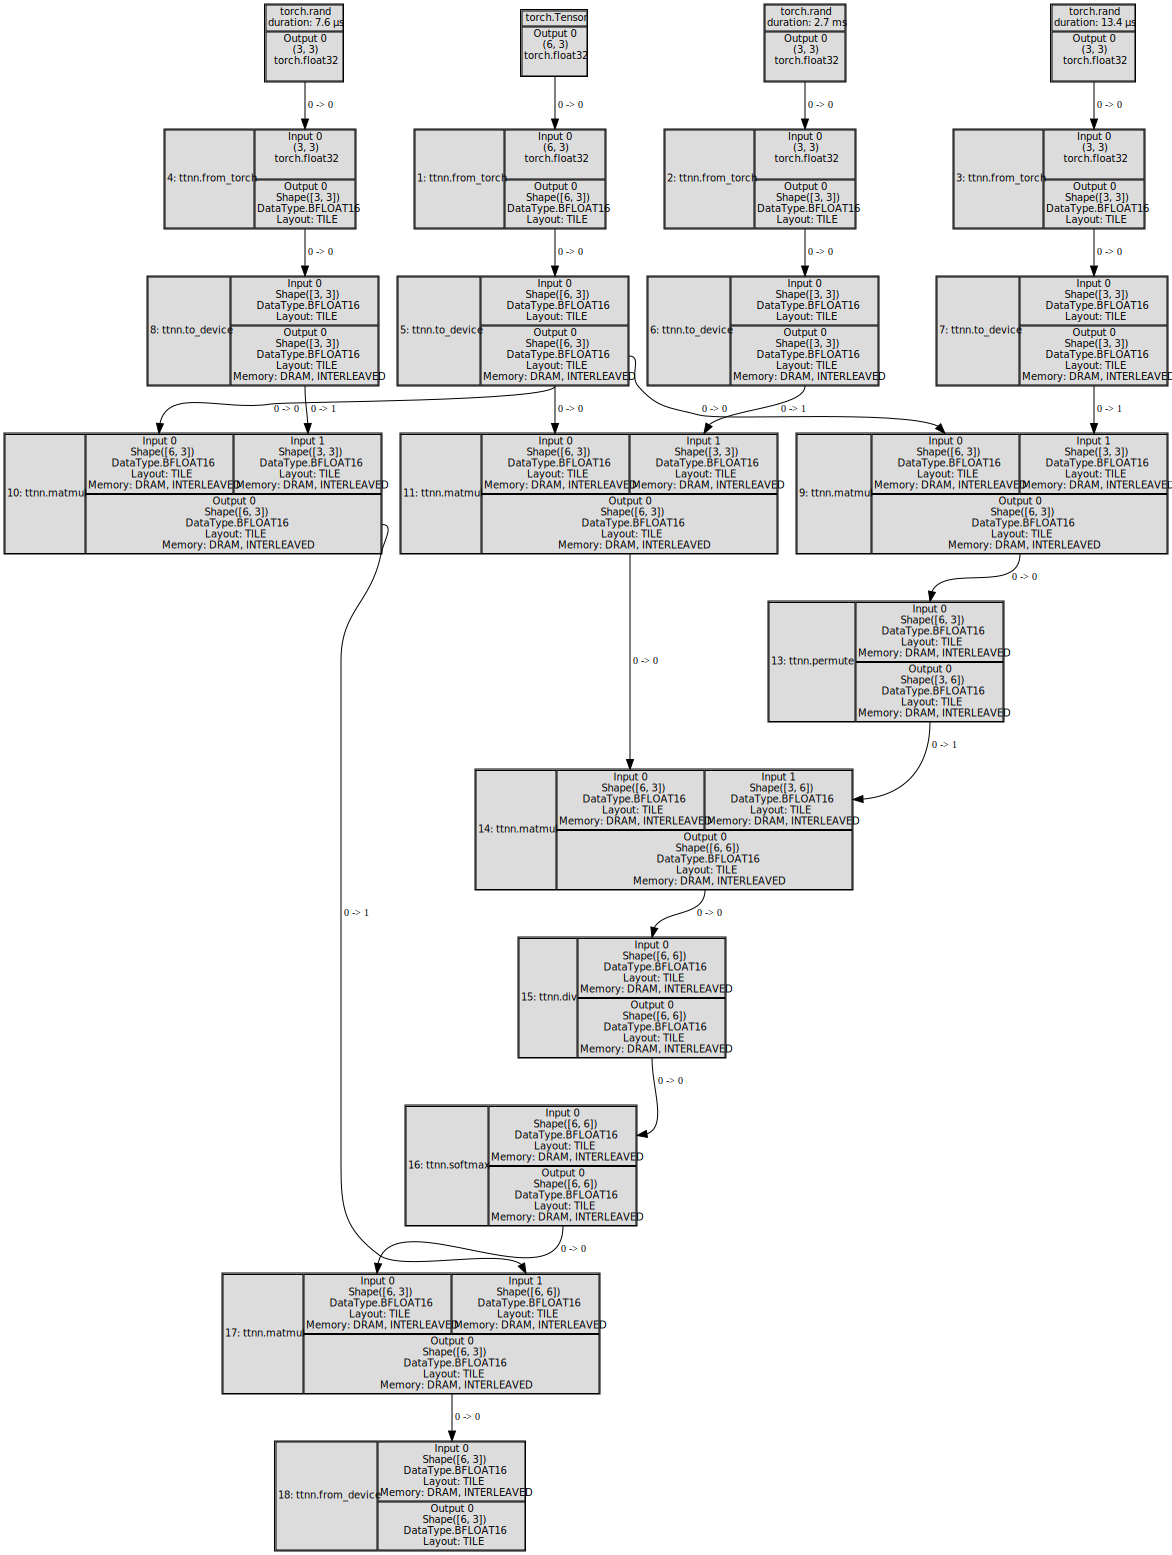

In [36]:
visualize(context_vecs_ttnn)

In [37]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0


In [38]:
context_vecs

tensor([[0.6679, 1.0240, 1.1094],
        [0.6856, 1.0544, 1.1388],
        [0.6853, 1.0538, 1.1382],
        [0.6728, 1.0328, 1.1173],
        [0.6700, 1.0274, 1.1130],
        [0.6773, 1.0408, 1.1247]])

In [39]:
context_vecs_ttnn

ttnn.Tensor([[ 0.66406,  1.01562,  1.10156],
             [ 0.67188,  1.03906,  1.11719],
             ...,
             [ 0.66406,  1.01562,  1.10156],
             [ 0.67188,  1.03125,  1.11719]], shape=Shape([6, 3]), dtype=DataType::BFLOAT16, layout=Layout::TILE)